In [1]:
# base 
import os 
import sys
from src import helpers, config, plotting, evaluation
import random 
import json 
import numpy as np
import pandas as pd 
import pandas.api.types as types
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import pickle
import logging
from pathlib import Path
from urllib.request import urlretrieve 
from typing import List, Set, Dict, Tuple
from typing import Union, Any, Optional, Iterable, Hashable, Type

# base
from sklearn.base import TransformerMixin

# ml preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

# models
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# validation 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix

# pipelines 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display='diagram')


# yet to arrange
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# test
assert config.TRAIN_FILE_PATH == Path.cwd().parent / "data" / "final"
assert config.REPORTS_PATH == Path.cwd().parent / "reports" / "figures"
assert config.RAW_FILE_PATH == Path.cwd().parent / "data" / "raw"

In [3]:
%matplotlib inline 
sns.set_style('white')
sns.set_palette('deep')
mpl.rcParams['figure.figsize'] = config.DEFAULT_FIGSIZE
mpl.rcParams['lines.linewidth'] = config.DEFAULT_PLOT_LINEWIDTH
mpl.rcParams['lines.linestyle'] = config.DEFAULT_PLOT_LINESTYLE
mpl.rcParams['font.size'] = config.DEFAULT_AXIS_FONT_SIZE

# logging settings 
# logging.basicConfig(level=logging.DEBUG, format='%(levelname)s:%(message)s')
logger = logging.getLogger()
logger.disabled = False

pd.set_option('display.max_columns', 30)
TARGET = 'status'

In [24]:
# download and place data in the raw folder
raw_filename = 'Loan_Default.csv'
if os.path.exists(config.RAW_FILE_PATH / raw_filename): 
    print(f'READING FROM THE LOCAL COPY')
    df = pd.read_csv(config.RAW_FILE_PATH / raw_filename)
else: 
    print(f'FILE DOES NOT EXIST: {raw_filename}')
    print('DOWNLOADING DATA >>>')
    df = pd.read_csv('gs://aml_1/Loan_Default.csv')
    df.to_csv(config.RAW_FILE_PATH / raw_filename)
df.head()

FILE DOES NOT EXIST: Loan_Default.csv
DOWNLOADING DATA >>>


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,...,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,...,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,...,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,...,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,...,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,...,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [5]:
df.columns = helpers.standardize_cols(df.columns)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   unnamed:_0                 148670 non-null  int64  
 1   id                         148670 non-null  int64  
 2   year                       148670 non-null  int64  
 3   loan_limit                 145326 non-null  object 
 4   gender                     148670 non-null  object 
 5   approv_in_adv              147762 non-null  object 
 6   loan_type                  148670 non-null  object 
 7   loan_purpose               148536 non-null  object 
 8   credit_worthiness          148670 non-null  object 
 9   open_credit                148670 non-null  object 
 10  business_or_commercial     148670 non-null  object 
 11  loan_amount                148670 non-null  int64  
 12  rate_of_interest           112231 non-null  float64
 13  interest_rate_spread       11

### Hypotheses 
 
1. To drop 
    - unnamed:_0
    - id -> UID
    - year -> No variation 

2. Deterministic 
    - construction_type -> to drop 
    - secured_by -> drop 
    - security_type -> drop
    - open_credit -> consider dropping (imbalanced)

    Unsure of these
    - interest_rate_spread -> Not able to discriminate
    - rate_of_interest -> Not able to discriminate
    - upfront_charges -> Not able to discriminate

3. Applicant characteristics
    - gender -> Joint less likely to default -> Change to categorical
        - Engineer whether loan was joint or not??
        - Sex not provided?
    - age
    - dtir1 - debt to income ratio - missing 24121 values -> bin values?
    - region
    - income
    - credit_worthiness
    - credit_score
    - credit_type
    - co_applicant_credit_type
    - submission_of_application

4. Loan details 
    - loan_type -> what is a type 2 loan? 
    - loan_limit -> missing values -> ncf tends to default more 
    - loan amount -> 
    - loan_purpose -> missing 134
    - lump_sum_payment -> remap 
    - approv_in_adv -> NA 908
    - term -> most likely not going to be discriminating
    - interest_only 
    - neg_ammortization -> seems important

5. Property
    - total_units (number of units bought?)
    - business_or_commercial -> higher chance of default if biz/comm
    - property_value
    - occupancy_type
    - ltv

<AxesSubplot:xlabel='ltv', ylabel='Density'>

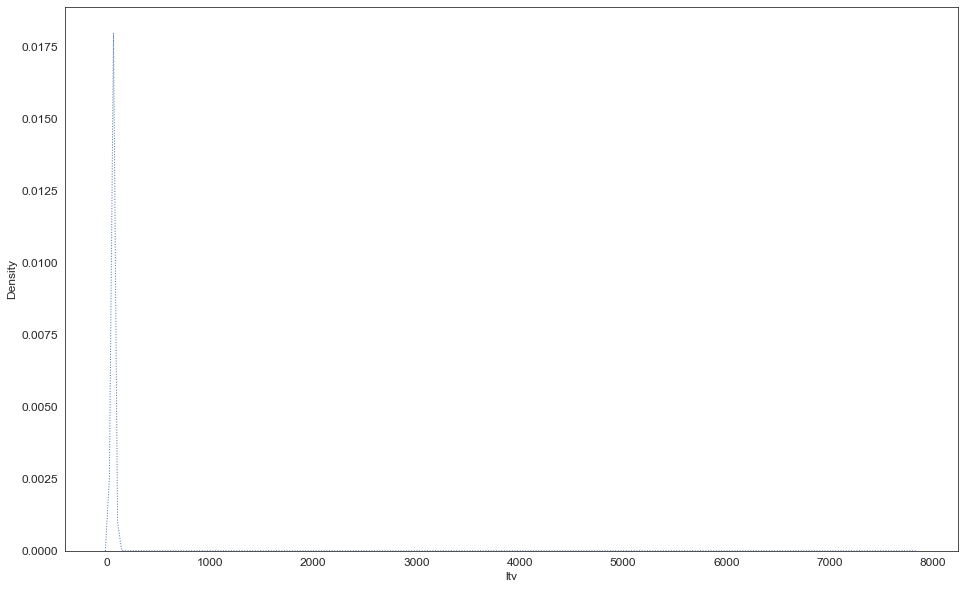

In [7]:
sns.kdeplot(df['ltv'])

In [8]:
'''
- interest_rate_spread -> Not able to discriminate
- rate_of_interest -> Not able to discriminate
- upfront_charges -> Not able to discriminate
'''
df.groupby(TARGET)['upfront_charges'].count()

status
0    108875
1       153
Name: upfront_charges, dtype: int64

In [9]:
df.groupby(TARGET)['open_credit'].value_counts(normalize=True)

status  open_credit
0       nopc           0.995912
        opc            0.004088
1       nopc           0.997325
        opc            0.002675
Name: open_credit, dtype: float64

### Dropping columns that are not useful

status
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: secured_by, dtype: object

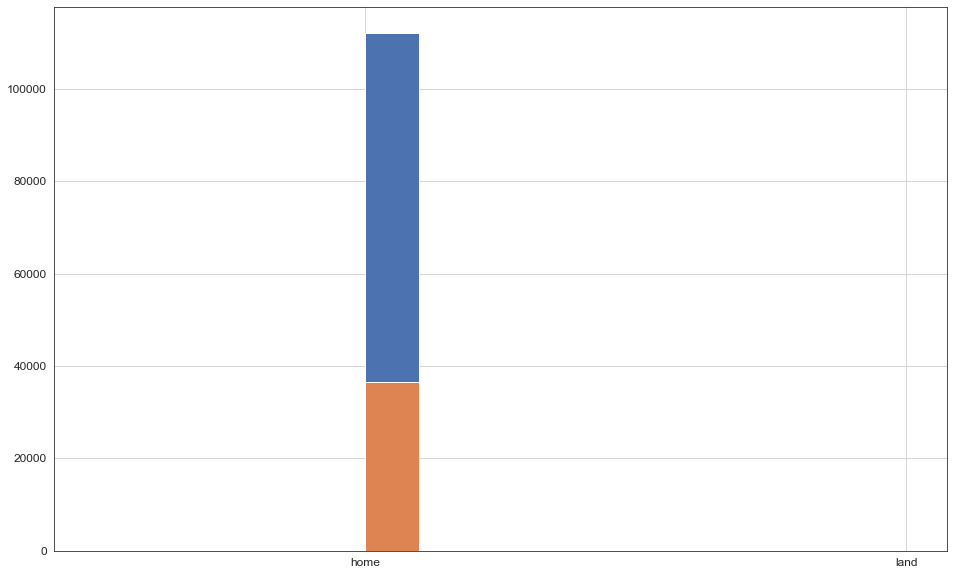

In [10]:
# df.groupby(TARGET)['secured_by'].value_counts()
df.groupby(TARGET)['secured_by'].hist()

In [27]:
df = df.drop(columns=['unnamed:_0', 'id', 'year', 'interest_rate_spread']) 
df = df.drop(columns=['secured_by', 'construction_type', 'security_type'])

KeyError: "['unnamed:_0' 'id' 'interest_rate_spread'] not found in axis"

### Applicant Characteristics
    - gender -> Joint less likely to default -> Change to categorical
        - Engineer whether loan was joint or not??
        - Sex not provided?
    - age
    - dtir1 - debt to income ratio - missing 24121 values -> bin values?
    - region
    - income
    - credit_worthiness
    - credit_score
    - credit_type
    - co_applicant_credit_type
    - submission_of_application

array(['25-34', '55-64', '35-44', '45-54', '65-74', '>74', '<25', nan],
      dtype=object)

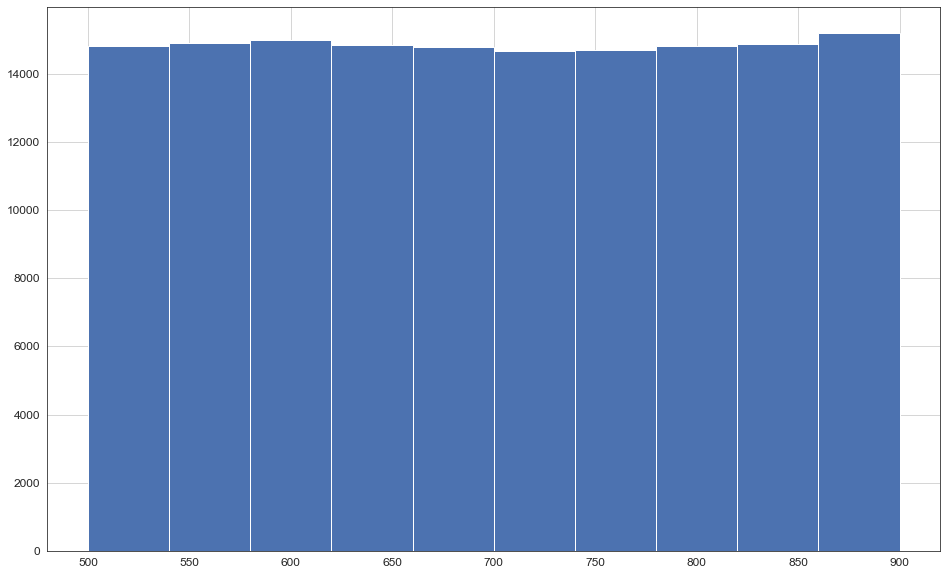

In [12]:
##  gender
## ============================================
df['gender'] = helpers.convert_to_dtype(df['gender'], type='categorical')
# df['gender'].nunique()
# df['gender'].value_counts()
# df['joint_loan'] = df['gender'].apply(lambda x: x == 'Joint')


## age 
## ============================================
display(df['age'].unique())
age_bins = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']
age_cat = pd.CategoricalDtype(categories=age_bins, ordered=True)

df['age'] = df['age'].astype(age_cat)


## region 
## ============================================
# standardize to lowercase
df['region'] = df['region'].str.lower().astype('category')


## credit_worthiness 
## ============================================
df['credit_worthiness'] = df['credit_worthiness'].astype('category')


## credit_score 
## ============================================
# no changes so far
df['credit_score'] = df['credit_score']
df['credit_score'].hist()

## credit_type / co_applicant_credit_type
## ============================================
df['credit_type'].value_counts()
df['credit_type'] = df['credit_type'].astype('category')

df['co_applicant_credit_type'] = df['co_applicant_credit_type'].astype('category')
df['co_applicant_credit_type'].isna().sum()


## submission_of_application
## ============================================
df['submission_of_application'] = df['submission_of_application'].astype('category')

In [13]:
## income
## ============================================
df['income'].describe().T
df[df['income'] == df['income'].max()]

# large incomes
display(df['income'].nlargest(10))

# check if any negative incomes
assert df['income'].min() >= 0

## debt to income ratio 
## ============================================
df['dtir1'].isna().sum()
# 24121 missing

df['dtir1'].dtype
# df['dtir1'].hist()

62237     578580.0
33621     377220.0
65351     374400.0
46142     335880.0
60996     335880.0
8892      329460.0
114559    322860.0
117307    312000.0
117248    240000.0
31674     235980.0
Name: income, dtype: float64

dtype('float64')

### Loan details
    - loan_type -> what is a type 2 loan? 
    - loan_limit -> missing values -> ncf tends to default more 
    - loan amount -> 
    - loan_purpose -> missing 134
    - lump_sum_payment -> remap 
    - approv_in_adv -> NA 908
    - term -> most likely not going to be discriminating
    - interest_only 
    - neg_ammortization -> seems important

In [14]:
def remove_outliers(): pass

In [15]:
std = df['loan_amount'].std()
mean = df['loan_amount'].mean()

# calculate the cutoff
cut_off = std * 3

# upper and lower limit 
lower, upper = mean - cut_off, mean + cut_off

outlier_df = df[~((df['loan_amount'] < upper) & (df['loan_amount'] > lower))]
outlier_df['loan_amount'].sort_values(ascending=False)

4321      3576500
98146     3346500
54519     3006500
86408     3006500
121640    3006500
           ...   
78500      886500
145020     886500
140825     886500
140769     886500
20546      886500
Name: loan_amount, Length: 1371, dtype: int64

status         
0       not_neg    103560
        neg_amm      8382
1       not_neg     29860
        neg_amm      6747
Name: neg_ammortization, dtype: int64

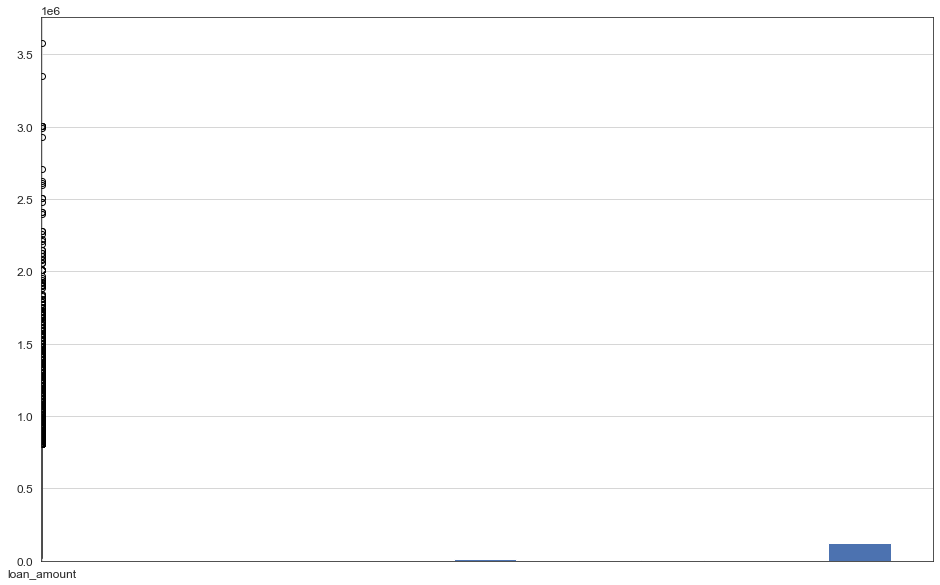

In [16]:
## loan_type
## ============================================
df['loan_type'] = helpers.convert_to_dtype(df['loan_type'], 'categorical')


## loan_limit 3344 missing values
# - CF = conforming loan 
# - NCF = non-conforming loan
## ============================================
df['loan_limit'] = df['loan_limit'].astype('category')
df['loan_limit'].isna().sum()


## loan_amount
## ============================================
df[['loan_amount']].boxplot()


## loan_purpose
## ============================================
df['loan_purpose'] = helpers.convert_to_dtype(df['loan_purpose'], 'categorical')


## lump_sum_payment
## ============================================
df['lump_sum_payment'].value_counts()

lump_sum_mapping = {'not_lpsm': False, 'lpsm': True}  
df['lump_sum_payment'] = df['lump_sum_payment'].map(lump_sum_mapping).astype('category')
# df.groupby('status')['lump_sum_payment'].value_counts(normalize=True)


## approv_in_adv -> missing 908
## ============================================
df['approv_in_adv'] = df['approv_in_adv'].astype('category')

## term bin values? 
## ============================================
df['term'].hist()


## interest_only 
## ============================================
'''
What Is an Interest-Only Mortgage? An interest-only mortgage is a type of 
mortgage in which the mortgagor (the borrower) is required to pay only the 
interest on the loan for a certain period. The principal is repaid either 
in a lump sum at a specified date, or in subsequent payments.
'''
interest_only_mapping = {'not_int': False, 'int_only': True}  
df['interest_only'] = df['interest_only'].map(interest_only_mapping).astype('category')
df['interest_only'].value_counts()

## neg_ammortization 
## ============================================
df['neg_ammortization'] = df['neg_ammortization'].astype('category')

df.groupby(TARGET).neg_ammortization.value_counts()

In [17]:
# df['loan_amount'].head(10)
df.loc[df['loan_amount'].nsmallest(50).index,:]

,loan_limit,gender,approv_in_adv,loan_type,loan_purpose,credit_worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,upfront_charges,term,neg_ammortization,interest_only,lump_sum_payment,property_value,occupancy_type,total_units,income,credit_type,credit_score,co_applicant_credit_type,age,submission_of_application,ltv,region,status,dtir1
124860,cf,Female,pre,type2,p2,l1,nopc,b/c,16500,NaN,NaN,360.0,not_neg,False,False,88000.0,pr,1U,1380.0,EXP,715,CIB,>74,to_inst,18.750000,north,1,51.0
135325,cf,Male,NaN,type2,p1,l1,nopc,b/c,16500,NaN,NaN,360.0,not_neg,False,False,NaN,pr,1U,2580.0,EQUI,815,EXP,<25,to_inst,NaN,north,1,NaN
136556,cf,Sex Not Available,pre,type3,p1,l1,nopc,nob/c,16500,NaN,NaN,180.0,not_neg,False,False,18000.0,pr,1U,2820.0,EXP,771,CIB,55-64,to_inst,91.666667,central,1,37.0
205,cf,Sex Not Available,nopre,type2,p2,l1,nopc,b/c,26500,4.750,662.44,360.0,neg_amm,False,False,78000.0,pr,1U,1260.0,EXP,569,CIB,55-64,to_inst,33.974359,south,0,24.0
17809,cf,Sex Not Available,nopre,type2,p2,l1,nopc,b/c,26500,4.990,408.94,360.0,not_neg,False,False,138000.0,pr,1U,1260.0,EXP,840,CIB,>74,to_inst,19.202899,south,0,11.0
19240,cf,Female,nopre,type2,p2,l1,nopc,b/c,26500,4.250,537.76,360.0,neg_amm,False,False,118000.0,pr,1U,1140.0,CRIF,594,CIB,65-74,to_inst,22.457627,north,0,20.0
30406,cf,Sex Not Available,nopre,type2,p1,l1,nopc,b/c,26500,NaN,NaN,360.0,not_neg,False,False,38000.0,pr,1U,840.0,EXP,646,CIB,55-64,to_inst,69.736842,south,1,38.0
34764,cf,Sex Not Available,nopre,type2,p3,l1,nopc,b/c,26500,NaN,NaN,360.0,not_neg,False,False,78000.0,pr,1U,1740.0,EXP,589,CIB,55-64,to_inst,33.974359,south,1,36.0
43224,cf,Sex Not Available,nopre,type2,p1,l1,nopc,b/c,26500,NaN,NaN,300.0,not_neg,False,False,28000.0,pr,1U,1980.0,EXP,672,CIB,25-34,to_inst,94.642857,south,1,29.0
44394,cf,Female,nopre,type2,p2,l1,nopc,b/c,26500,5.375,325.58,360.0,NaN,False,False,138000.0,pr,1U,1500.0,CIB,749,CIB,65-74,to_inst,19.202899,north,0,11.0


### Property related
    - total_units (number of units bought?)
    - business_or_commercial -> higher chance of default if biz/comm
    - property_value
    - occupancy_type
    - ltv

In [29]:
## total_units 
## ============================================
total_units_cat = pd.CategoricalDtype(categories=['1U', '2U', '3U', '4U'], ordered=True)
df['total_units'] = df['total_units'].astype(total_units_cat)
# df.groupby(TARGET)['total_units'].value_counts(normalize=True)


## business_or_commercial 
## ============================================
df['business_or_commercial'] = df['business_or_commercial'].astype('category')
# df.groupby(TARGET)['business_or_commercial'].value_counts(normalize=True)


## property_value 
## ============================================
df[['property_value']]


## occupancy_type 
## ============================================
occupancy_type_map = {'pr': 'primary residence', 'sr': 'secondary residence', 'ir': 'investment residence'}
df['occupancy_type'] = df['occupancy_type'].map(occupancy_type_map).astype('category')
df['occupancy_type'].value_counts(normalize=True)

## ltv 
## ============================================
df[['ltv']]
# df.groupby(TARGET)['total_units'].value_counts(normalize=True)

KeyError: "None of [Index(['ltv'], dtype='object')] are in the [columns]"

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   id                         148670 non-null  int64   
 1   year                       148670 non-null  int64   
 2   loan_limit                 145326 non-null  object  
 3   gender                     148670 non-null  object  
 4   approv_in_adv              147762 non-null  object  
 5   loan_type                  148670 non-null  object  
 6   loan_purpose               148536 non-null  object  
 7   credit_worthiness          148670 non-null  object  
 8   open_credit                148670 non-null  object  
 9   business_or_commercial     148670 non-null  category
 10  loan_amount                148670 non-null  int64   
 11  rate_of_interest           112231 non-null  float64 
 12  interest_rate_spread       112031 non-null  float64 
 13  upfront_charge

In [ ]:
property_value_nm = df[~df['property_value'].isna()]
df['property_value'].isna().sum() / df.shape[0]
property_value_nm['status'].value_counts(normalize=True)

0.10155377682114751

### upfront_charges, construction_type, interest_rate_spread
- Missing values for all status with loan defaults
- ??? 

In [ ]:
df.groupby(TARGET)['upfront_charges'].mean()

# df.pivot_table(values=loan, index=TARGET)

df['construction_type'].isna().sum()

sns.histplot(data=df, x='interest_rate_spread', hue=TARGET)
plt.show()

KeyError: 'construction_type'

### Loan purpose indepth

In [ ]:
df['loan_purpose'].value_counts()

cat_features = helpers.get_categorical_columns(df)

for col in cat_features:
    df_bar = df.groupby('loan_purpose')[col].value_counts().to_frame('counts').reset_index()
    sns.catplot(data=df_bar, x='gender', y='counts', row='loan_purpose', kind='bar')

In [ ]:
df.groupby(TARGET)['security_type'].value_counts()

status  security_type
0       direct           112031
1       direct            36606
        Indriect             33
Name: security_type, dtype: int64

### Missing loan limits indepth

In [ ]:
missing_loan_limits = df.loc[df['approv_in_adv'].isna()]
non_missing_loan_limits = df.loc[~df['approv_in_adv'].isna()]

missing_loan_limits = missing_loan_limits.drop(columns='approv_in_adv')

display(missing_loan_limits.describe().T)
display(non_missing_loan_limits.describe().T)

sns.pairplot(missing_loan_limits)
plotting.quick_plot(missing_loan_limits)